# 实验5 课内竞赛-图像分类

**提示：**

- 默认安装`torch`、`torchvision`的CPU版本。如需使用GPU版本，需要先卸载（`pip uninstall torch torchvision`）并在[PyTorch官网](https://pytorch.org/get-started/locally/)上选择适合的架构重新安装。
    > **提示：** 将 https://download.pytorch.org/whl 替换为 https://mirrors.aliyun.com/pytorch-wheels 以使用阿里云镜像。
- 训练后的模型可以点此下载：[./cats_model.pth](./cats_model.pth)；
- 本代码已设置随机数据增强，因此训练准确度偶见过低，此时重新训练即可；
- 你可以将图片放置在[./custom_test/](./custom_test/)文件夹中并转到[从图片读取并测试](#从图片读取并测试)一节，重新运行单元格即可使用自定义图片检测；
- 只推荐下载到本地自行训练，在线服务器资源有限，可能因内存溢出而导致内核崩溃。

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
import torch.nn as nn
import sys
import platform
import h5py
import collections
import pandas as pd
import math
import numpy as np
from pathlib import Path
import os
from PIL import Image

## 训练集

=======list_classes=======
list_classes's type: |S7
list_classes's shape: (2,)
list_classes's content: 
            0
0  b'non-cat'
1      b'cat'

=======train_set_x=======
train_set_x's type: uint8
train_set_x's shape: (209, 64, 64, 3)
train_set_x's content: 


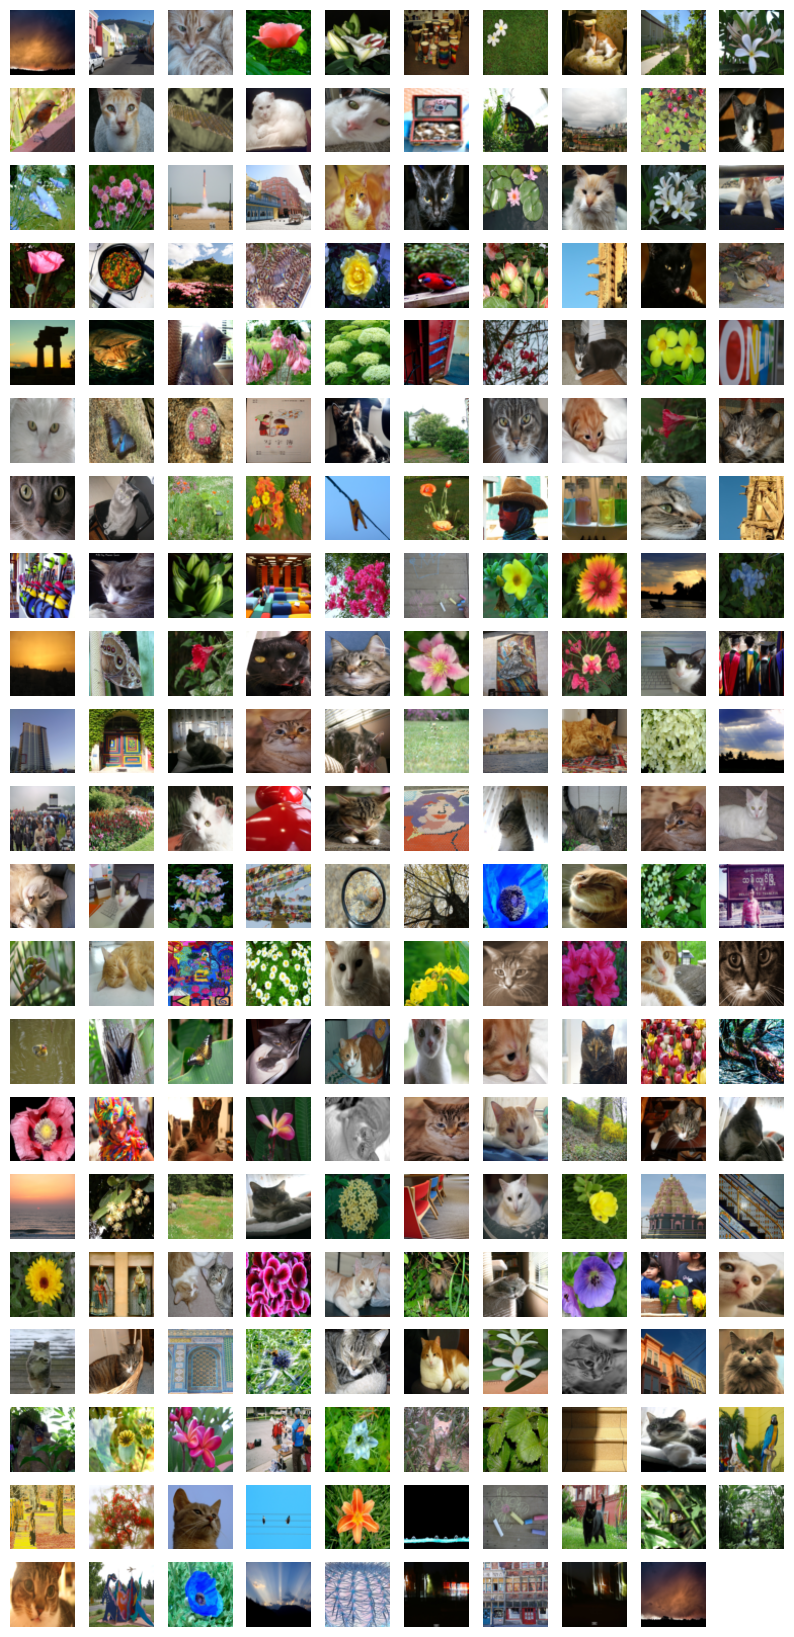


=======train_set_y=======
train_set_y's type: int64
train_set_y's shape: (209,)
train_set_y's content: 
     0
0    0
1    0
2    1
3    0
4    0
..  ..
204  0
205  0
206  0
207  0
208  0

[209 rows x 1 columns]



In [2]:
'''
用于获取某h5文件的键与内容。
'''

file = h5py.File('./datasets/cats/train_catvnoncat.h5', 'r')

for key in file.keys():
    print(f'======={key}=======')
    print(f'{key}\'s type: {file[key].dtype}')
    print(f'{key}\'s shape: {file[key].shape}')
    print(f'{key}\'s content: ')

    if file[key].dtype == np.uint8:

        w = 10
        h = math.ceil(file[key].shape[0]/w)

        fig, axs = plt.subplots(h, w, figsize=(w, h), dpi=100)
        imgs = file[key]
        total = len(imgs) - 1
        index = len(imgs) - 1
        for ax in axs:
            for a in ax:
                a.axis('off')
                if index != -1 :
                    a.imshow(imgs[total - index])
                    index = index - 1
        plt.show()

    else :
        print(pd.DataFrame(file[key]))

    print()



## 测试集

=======list_classes=======
list_classes's type: |S7
list_classes's shape: (2,)
list_classes's content: 
b'non-cat', b'cat', 
=======test_set_x=======
test_set_x's type: uint8
test_set_x's shape: (50, 64, 64, 3)
test_set_x's content: 


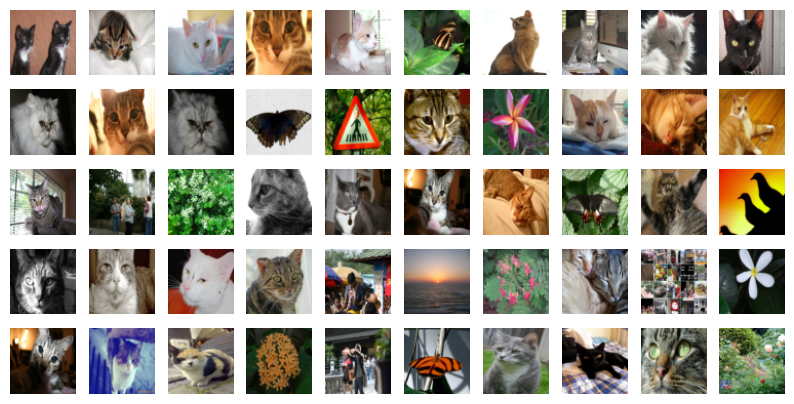


=======test_set_y=======
test_set_y's type: int64
test_set_y's shape: (50,)
test_set_y's content: 
1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 


In [3]:
'''
用于获取某h5文件的键与内容。
'''

file = h5py.File('./datasets/cats/test_catvnoncat.h5', 'r')

for key in file.keys():
    print(f'======={key}=======')
    print(f'{key}\'s type: {file[key].dtype}')
    print(f'{key}\'s shape: {file[key].shape}')
    print(f'{key}\'s content: ')

    if file[key].dtype == np.uint8:

        w = 10
        h = math.ceil(file[key].shape[0]/w)

        fig, axs = plt.subplots(h, w, figsize=(w, h), dpi=100)
        imgs = file[key]
        total = len(imgs) - 1
        index = len(imgs) - 1
        for ax in axs:
            for a in ax:
                a.axis('off')
                if index != -1 :
                    a.imshow(imgs[total - index])
                    index = index - 1
        plt.show()

    else :
        for array in file[key]:
            print(array, end=', ')

    print()
            


## 模型训练

### CUDA检测

In [4]:
torch_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'=========== System Info ===========')
print(f'系统架构: {sys.platform}')
print(f'Python版本: {platform.python_version()}')
print(f'Python构建元数据: {sys.version}')
print(f'PyTorch版本: {torch.__version__}')
print(f'PyTorch计算平台: {torch_device}')
print(f'PyTorch的cuDNN可用性: {torch.backends.cudnn.enabled}')

=========== System Info ===========
系统架构: win32
Python版本: 3.12.0
Python构建元数据: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:26:13) [MSC v.1935 64 bit (AMD64)]
PyTorch版本: 2.8.0+cpu
PyTorch计算平台: cpu
PyTorch的cuDNN可用性: True


### 定义Dataset

In [5]:
class CatsDataset (Dataset):

    def __init__(self, p5_dataset_file_path, inputs_key_name, target_key_name, transform = None, ) :
        self.p5_file = p5_dataset_file_path
        self.transform = transform
        self.target_key = inputs_key_name
        self.label_key = target_key_name

        self.dataset = [] # [(img, label),...]

        self._get_dataset_info()

    def __getitem__(self, item):
        image, label = self.dataset[item]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        if len(self.dataset) == 0:
            raise RuntimeError(f'h5文件： {self.p5_file} 不正确')

        return len(self.dataset)

    def _get_dataset_info(self):
        data = h5py.File(self.p5_file, 'r')

        target = data[self.target_key][:]
        label = data[self.label_key][:]

        dataset = list(zip(target, label))
        self.dataset = dataset

### 定义DataLoader

In [6]:
train_set = CatsDataset(
    p5_dataset_file_path='./datasets/cats/train_catvnoncat.h5',
    inputs_key_name='train_set_x',
    target_key_name='train_set_y',
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(
            (64,64),
            scale=(0.7, 1.2),
            ratio=(0.9, 1.1)
        ),
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.2,
            # saturation=0.2,
            # hue=0.2
        )
    ])
)

train_targets_label = [s[1] for s in train_set.dataset]
label_sets_count = collections.Counter(train_targets_label)
label_sets_count = [label_sets_count[k] for k in sorted(label_sets_count)]

weights = 1. / torch.tensor(label_sets_count, dtype=torch.float)

targets_weights = weights[train_targets_label]

train_loader_sampler = WeightedRandomSampler(
    weights=targets_weights,
    num_samples=len(targets_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_set,
    batch_size=32,
    drop_last=True,
    sampler=train_loader_sampler
)

test_loader = DataLoader(
    CatsDataset(
        p5_dataset_file_path='./datasets/cats/test_catvnoncat.h5',
        inputs_key_name='test_set_x',
        target_key_name = 'test_set_y',
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=50,
    drop_last=False
)


==========第0次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：15
负样本：17
采样比：0.8823529411764706
==========第1次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：18
负样本：14
采样比：1.2857142857142858
==========第2次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：19
负样本：13
采样比：1.4615384615384615
==========第3次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：16
负样本：16
采样比：1.0
==========第4次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：12
负样本：20
采样比：0.6
==========第5次取样==========
inputs: torch.Size([32, 3, 64, 64])
targets: torch.Size([32])
正样本：13
负样本：19
采样比：0.6842105263157895


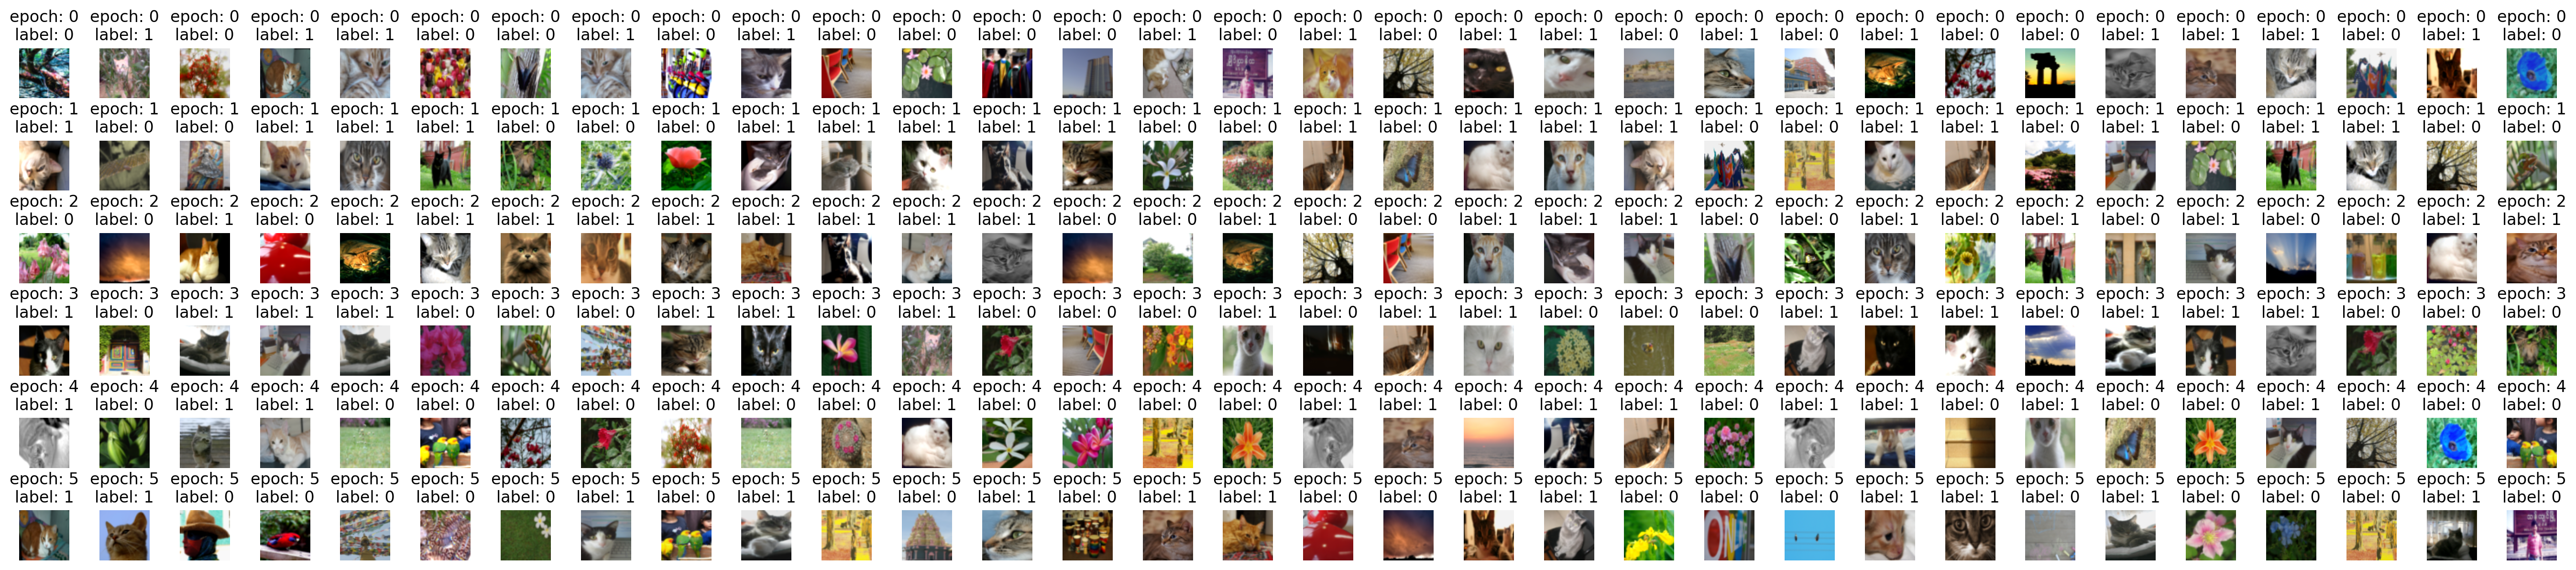

In [7]:
'''
测试随机采样器
'''
percent = []

fig, axs = plt.subplots(h:=len(train_loader), w:=train_loader.batch_size,
                        figsize=(w - 5,h),
                        dpi=200,
                        subplot_kw={'xticks': [], 'yticks': []})

for i, (inputs, targets) in enumerate(train_loader):
    print(f'==========第{i}次取样==========')
    print(f'inputs: {inputs.shape}')
    print(f'targets: {targets.shape}')
    positive_count = 0
    inpositive_count = 0

    for k, img in enumerate(inputs):
        img = img.permute(1, 2, 0).numpy()
        axs[i, k].imshow(img)
        axs[i, k].axis('off')
        axs[i, k].set_title(f'epoch: {i}\nlabel: {targets[k]}')

        if targets[k] == 1: positive_count += 1
        else : inpositive_count += 1

    print(f'正样本：{positive_count}')
    print(f'负样本：{inpositive_count}')

    if inpositive_count != 0:
        percent.append(positive_count / inpositive_count)
        print(f'采样比：{percent[i]}')
    else:
        percent.append(0)

plt.tight_layout()
plt.show()

### 定义模型和初始化参数

In [8]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64 * 64 * 3, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0, std=0.001)

model.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=1, bias=True)
  (7): Sigmoid()
)

### 定义损失函数、优化方法

In [9]:
loss_func = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=10.0)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epoch = 500

### 模型训练

In [10]:
train_loss = []
test_loss = []
test_acc = []

for e in range(epoch):

    model.train()
    train_loss_log = []
    for i, (x, y) in enumerate(train_loader):
        X, Y = x.to(torch_device), y.to(torch_device)
        y_pred = model(X)
        optimizer.zero_grad()
        loss = loss_func(y_pred, torch.unsqueeze(Y,dim=1).float())
        loss.backward()
        optimizer.step()
        train_loss_log.append(loss.item())
    train_loss.append(sum(train_loss_log) / len(train_loss_log))

    model.eval()
    test_loss_log = []
    test_acc_log = [0, 0] # [correct, num]
    for i, (x, y) in enumerate(test_loader):
        X, Y = x.to(torch_device), y.to(torch_device)
        y_pred = model(X)
        loss = loss_func(y_pred, torch.unsqueeze(Y,dim=1).float())
        test_loss_log.append(loss.item())

        test_acc_log[0] += torch.eq(torch.gt(y_pred, 0.5), Y.unsqueeze(dim=1)).sum().item()
        test_acc_log[1] += X.shape[0]

    test_loss.append(sum(test_loss_log) / len(test_loss_log))
    test_acc.append(test_acc_log[0] / test_acc_log[1])

    print(f'=========Epoch{e + 1} / {epoch}=========')
    print(f'Test Loss: {test_loss[-1]}')
    print(f'Test Accuarcy: {test_acc[-1]}')

=========Epoch1 / 500=========
Test Loss: 0.6871271729469299
Test Accuarcy: 0.66
=========Epoch2 / 500=========
Test Loss: 0.6867615580558777
Test Accuarcy: 0.66
=========Epoch3 / 500=========
Test Loss: 0.6865336894989014
Test Accuarcy: 0.66
=========Epoch4 / 500=========
Test Loss: 0.6872016787528992
Test Accuarcy: 0.66
=========Epoch5 / 500=========
Test Loss: 0.685773491859436
Test Accuarcy: 0.66
=========Epoch6 / 500=========
Test Loss: 0.683889627456665
Test Accuarcy: 0.66
=========Epoch7 / 500=========
Test Loss: 0.6805742383003235
Test Accuarcy: 0.66
=========Epoch8 / 500=========
Test Loss: 0.682326078414917
Test Accuarcy: 0.66
=========Epoch9 / 500=========
Test Loss: 0.684474766254425
Test Accuarcy: 0.66
=========Epoch10 / 500=========
Test Loss: 0.6869127154350281
Test Accuarcy: 0.66
=========Epoch11 / 500=========
Test Loss: 0.6862901449203491
Test Accuarcy: 0.66
=========Epoch12 / 500=========
Test Loss: 0.6834086775779724
Test Accuarcy: 0.66
=========Epoch13 / 500=======

#### 训练后评估

In [11]:
pd.DataFrame({'训练集平均损失': train_loss,
              '测试集平均损失': test_loss,
              '测试集准确度': test_acc})

训练集平均损失   测试集平均损失  测试集准确度
0    0.692380  0.687127    0.66
1    0.692340  0.686762    0.66
2    0.693665  0.686534    0.66
3    0.694394  0.687202    0.66
4    0.688353  0.685773    0.66
..        ...       ...     ...
495  0.276457  0.447518    0.84
496  0.325710  0.615484    0.68
497  0.351221  0.476177    0.78
498  0.341755  0.547716    0.68
499  0.304481  0.430635    0.84

[500 rows x 3 columns]

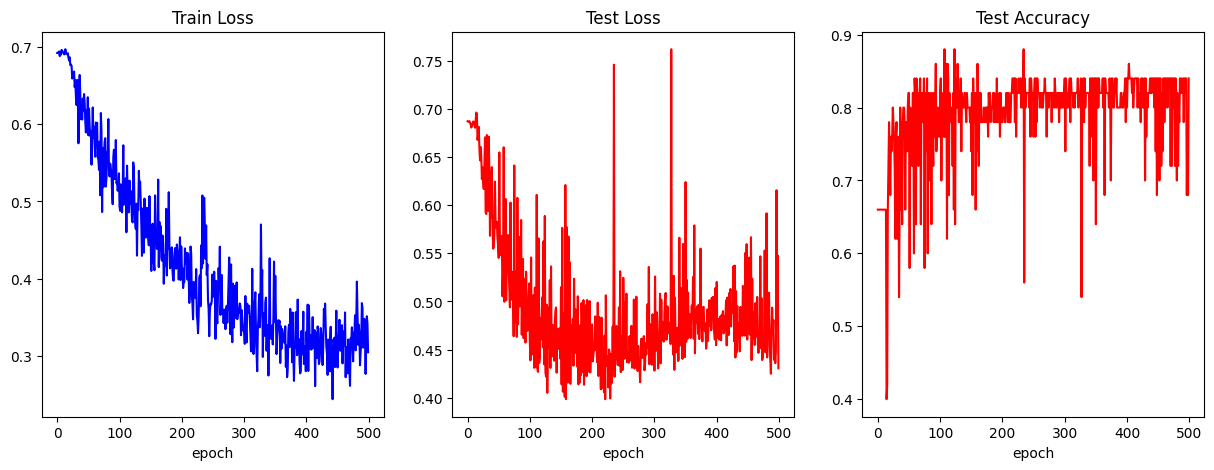

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(131, title='Train Loss')
plt.plot(range(len(train_loss)), train_loss, color='b', label='Train Loss')
plt.xlabel('epoch')

plt.subplot(132, title='Test Loss')
plt.plot(range(len(test_loss)), test_loss,  color='r',label='Test Loss')
plt.xlabel('epoch')

plt.subplot(133, title='Test Accuracy')
plt.plot(range(len(test_acc)), test_acc, color='r', label='Test Accuracy')
plt.xlabel('epoch')
plt.show()

### 模型保存

In [13]:
save_path = Path('./')
save_path.mkdir(parents=True, exist_ok=True)

if save_path.is_dir():
    save_path = Path(os.path.join(save_path, 'cats_model.pth'))

torch.save(model, str(save_path))

print(f'已保存至：{str(save_path)}')


已保存至：cats_model.pth


### 模型性能评估

#### 从h5py文件测试

In [14]:
pth_path = save_path
dataset_path = Path('./datasets/cats/test_catvnoncat.h5')

if pth_path.is_dir(): raise RuntimeError(f'path {str(pth_path)} is dic, not file.')
if pth_path.suffix != '.pth': raise RuntimeError(f'{str(pth_path)} is not a *.pth file.')

if dataset_path.is_dir(): raise RuntimeError(f'path {str(dataset_path)} is dic, not file.')
if dataset_path.suffix != '.h5': raise RuntimeError(f'{str(dataset_path)} is not a *.h5 file.')

test_loader = DataLoader(
    CatsDataset(
        p5_dataset_file_path=str(dataset_path),
        inputs_key_name='test_set_x',
        target_key_name = 'test_set_y',
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=1,
    drop_last=False
)

custom_model = torch.load(str(pth_path), weights_only=False)
custom_model.eval()

loss_log = []
predic_log = []
sample_log = []
label_log = []

for i, (x, y) in enumerate(test_loader):
    X = x.to(torch_device)
    Y = y.to(torch_device)

    y_pred = custom_model(X)
    y_float = torch.unsqueeze(Y,dim=1).float()
    loss = loss_func(y_pred, torch.unsqueeze(Y,dim=1).float())

    loss_log.append(loss.item())
    predic_log.append(y_pred.item())
    sample_log.append(x.squeeze())
    label_log.append(y.squeeze())


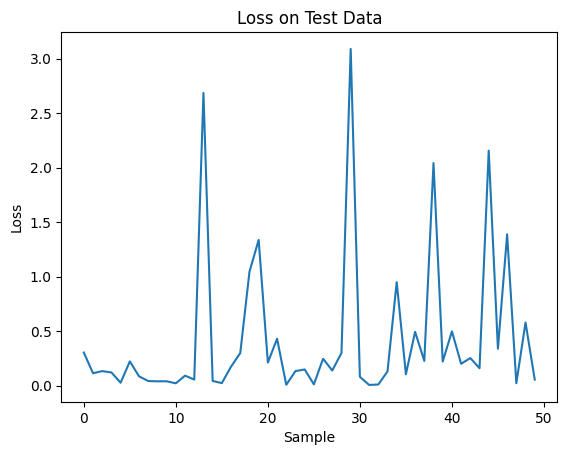

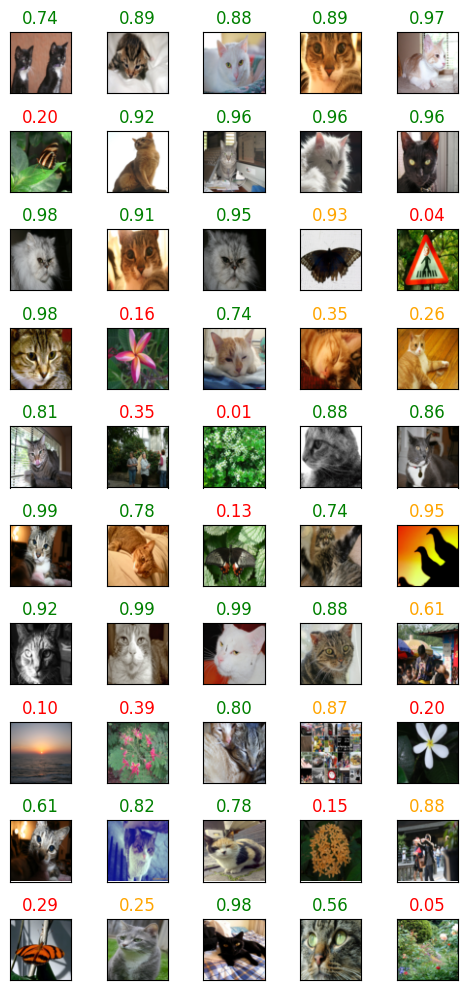

C:\Users\happy\AppData\Local\Temp\ipykernel_15936\3128499586.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (p[p['label_log'] == 1][p['predic_log'] > 0.5]['predic_log'].size
C:\Users\happy\AppData\Local\Temp\ipykernel_15936\3128499586.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  + p[p['label_log'] == 0][p['predic_log'] < 0.5]['predic_log'].size)


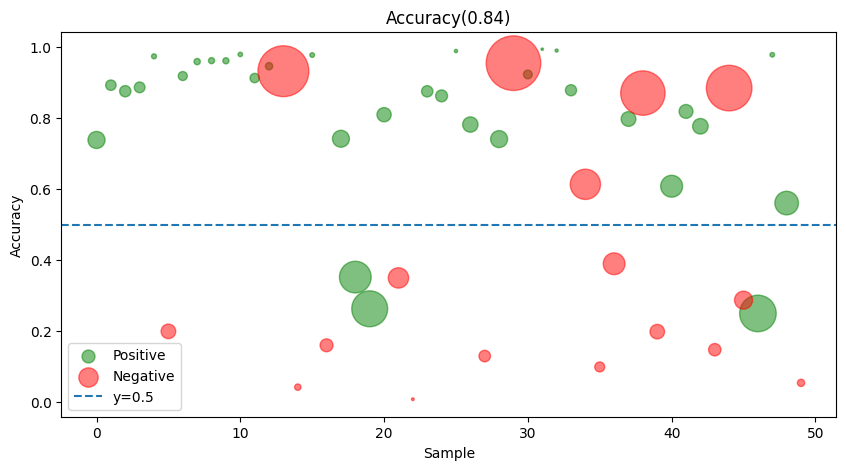

In [15]:
plt.plot(range(len(loss_log)), loss_log, label='Loss')
plt.title('Loss on Test Data')
plt.xlabel('Sample')
plt.ylabel('Loss')
plt.show()

fig, axs = plt.subplots(h:=math.ceil(len(sample_log)/5), 5,
                        figsize=(5, h),
                        subplot_kw=dict(xticks=[], yticks=[]))
axs = axs.ravel()

for i, (img, pred, label) in enumerate(zip(sample_log, predic_log, label_log)):
    img_np = img.cpu().numpy()
    img_np = np.transpose(img_np, (1, 2, 0))
    axs[i].imshow(img_np)
    title_color = 'green' if pred > 0.5 and label == 1 else 'red' if pred < 0.5 and label == 0 else 'orange'
    axs[i].set_title(f'{pred:.2f}', color=title_color)

plt.tight_layout()
plt.show()

p = pd.DataFrame({'loss_log': loss_log,
                  'predic_log': predic_log,
                  'label_log': (l.item() for l in label_log)})

plt.figure(figsize=(10, 5))
plt.scatter(p[p['label_log'] == 1]['predic_log'].index, p[p['label_log'] == 1]['predic_log'],
            c='green',
            s=(p[p['label_log'] == 1]['loss_log'] * 500).values,
            alpha=0.5,
            label='Positive')
plt.scatter(p[p['label_log'] == 0]['predic_log'].index, p[p['label_log'] == 0]['predic_log'],
            c='red',
            s=(p[p['label_log'] == 0]['loss_log'] * 500).values,
            alpha=0.5,
            label='Negative')
plt.axhline(y=0.5, linestyle='--', label='y=0.5')
plt.title(f'Accuracy({
                    (p[p['label_log'] == 1][p['predic_log'] > 0.5]['predic_log'].size
                     + p[p['label_log'] == 0][p['predic_log'] < 0.5]['predic_log'].size)
                    / p['predic_log'].size:.2f})')
plt.xlabel('Sample')
plt.ylabel('Accuracy')
plt.legend(markerscale=0.5)
plt.show()

In [16]:
pd.DataFrame({'loss_log': loss_log,
              'predic_log': predic_log,
              'label_log': (l.item() for l in label_log)})

loss_log  predic_log  label_log
0   0.303579    0.738171          1
1   0.113724    0.892505          1
2   0.132966    0.875494          1
3   0.120590    0.886397          1
4   0.026538    0.973812          1
5   0.221878    0.198987          0
6   0.085288    0.918248          1
7   0.041907    0.958959          1
8   0.039116    0.961639          1
9   0.039531    0.961240          1
10  0.021102    0.979119          1
11  0.091455    0.912603          1
12  0.055521    0.945992          1
13  2.686587    0.931887          0
14  0.042681    0.041783          0
15  0.022820    0.977439          1
16  0.173986    0.159691          0
17  0.298970    0.741582          1
18  1.044554    0.351849          1
19  1.337319    0.262549          1
20  0.211485    0.809381          1
21  0.430073    0.349539          0
22  0.007834    0.007804          0
23  0.133300    0.875203          1
24  0.148113    0.862334          1
25  0.011383    0.988682          1
26  0.246369    0.781633          1
27  0.138559    0.129388          0
28  0.300260    0.740626          1
29  3.090392    0.954516          0
30  0.080449    0.922702          1
31  0.006216    0.993803          1
32  0.010010    0.990040          1
33  0.129844    0.878233          1
34  0.949878    0.613212          0
35  0.104012    0.098785          0
36  0.493356    0.389426          0
37  0.226571    0.797263          1
38  2.042561    0.870304          0
39  0.220833    0.198150          0
40  0.497871    0.607823          1
41  0.200217    0.818553          1
42  0.252641    0.776747          1
43  0.159354    0.147305          0
44  2.156847    0.884311          0
45  0.338149    0.286911          0
46  1.388554    0.249436          1
47  0.022078    0.978164          1
48  0.579049    0.560431          1
49  0.055388    0.053882          0

#### 从图片读取并测试

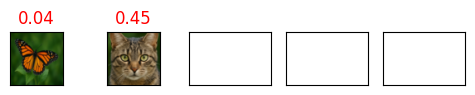

预测结果
0  0.043047
1  0.446475

In [17]:
pth_path = save_path
img_path = Path('./custom_test')

if pth_path.is_dir(): raise RuntimeError(f'path {str(pth_path)} is dic, not file.')
if pth_path.suffix != '.pth' : raise RuntimeError(f'{str(pth_path)} is not a *.pth file.')

custom_model = torch.load(str(pth_path), weights_only=False)
custom_model.eval()

def predict(single_img_path):

    img = Image.open(str(single_img_path))
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((64,64))])
    img = transform(img)

    X = img
    y_pred = custom_model(torch.unsqueeze(X, 0)).item()

    return y_pred, img

results = []
if img_path.is_file():
    predic_result, img_tensor = predict(img_path)
    plt.figure(dpi=60)
    plt.imshow(np.transpose(img_tensor, (1, 2, 0)))
    plt.title(f'Predict Result：{predic_result:.2f}')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    results = [predic_result]

elif img_path.is_dir():
    l = [p for p in img_path.rglob('*') if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}]
    fig, axs = plt.subplots(h:=math.ceil(len(l)/5), 5,
                            figsize=(5, h),
                            subplot_kw=dict(xticks=[], yticks=[]))
    axs = axs.ravel()

    for i, img_path in enumerate(l):
        predic_result, img_tensor = predict(img_path)
        title_color = 'green' if predic_result > 0.5 else 'red'
        axs[i].imshow(np.transpose(img_tensor, (1, 2, 0)))
        axs[i].set_title(f'{predic_result:.2f}',color=title_color)
        results.append(predic_result)

    plt.tight_layout()
    plt.show()

pd.DataFrame(results, columns=['预测结果'])
